In [1]:
'''
Colabl사용시:
!pip install botorch gpytorch
입력하여 botorch 및 gpytorch 가상머신에 설치
'''
import torch   #벡터(텐서)의 연산 및 미적분을 지원하는 라이브러리
torch.set_default_dtype(torch.float64) #더블 프리시전
torch.set_num_threads(2)#병렬 코어 2개까지만. 큰 문제를 사용할 때는 변경해도 무방
from botorch.models import SingleTaskGP #가우시안 프로세스 회귀 연산
from gpytorch.mlls import ExactMarginalLogLikelihood #내 모델과 데이터의 에러 계산
from botorch.fit import fit_gpytorch_mll #내 모델을 학습시키는 기능
from botorch.acquisition import LogExpectedImprovement # 기대 개선량 계산
from botorch.optim import optimize_acqf #기대개선 함수를 극대화하는 점 탐색
import matplotlib.pyplot as plt #그래프 가시화

from botorch.sampling import SobolQMCNormalSampler #효율적인 무작위 샘플링 지원


In [2]:
# 예제 정의.
# Objective function (e.g., a black-box function to optimize)
def objective_function(x):
    return ((x*torch.sin(20*x)*(1-x)))

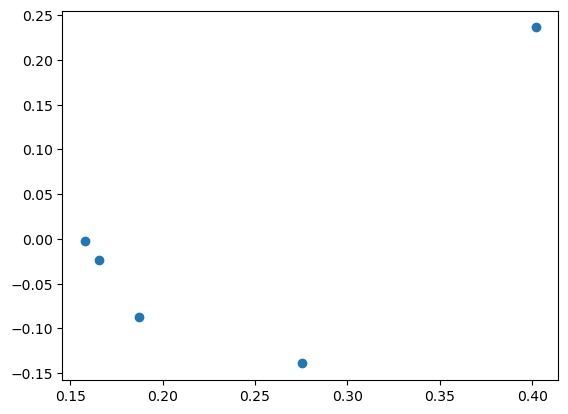

In [3]:
# Step 1: Initialize the search space and initial data
bounds = torch.tensor([[0.0], [1.0]]) #x의 범위
#bounds = torch.tensor([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]])  # 3D input space
num_initial_points = 5 #초기 시험된 점의 수

# Generate initial data
X_train = torch.rand(num_initial_points, 1)  # Random 3D points
Y_train = objective_function(X_train)  # Objective values, 현실 문제에 적용시에는 사용자가 입력.

# Step 2: Fit a Gaussian Process (GP) model
model = SingleTaskGP(X_train, Y_train) #GP 모델 생성

mll = ExactMarginalLogLikelihood(model.likelihood, model) #GP 모델의 우도 계산
fit_gpytorch_mll(mll); #입력된 데이터를 기반으로 GP 모델 학습 (우도 최대화 or loss 최소화) 
plt.plot(X_train,Y_train,'o')

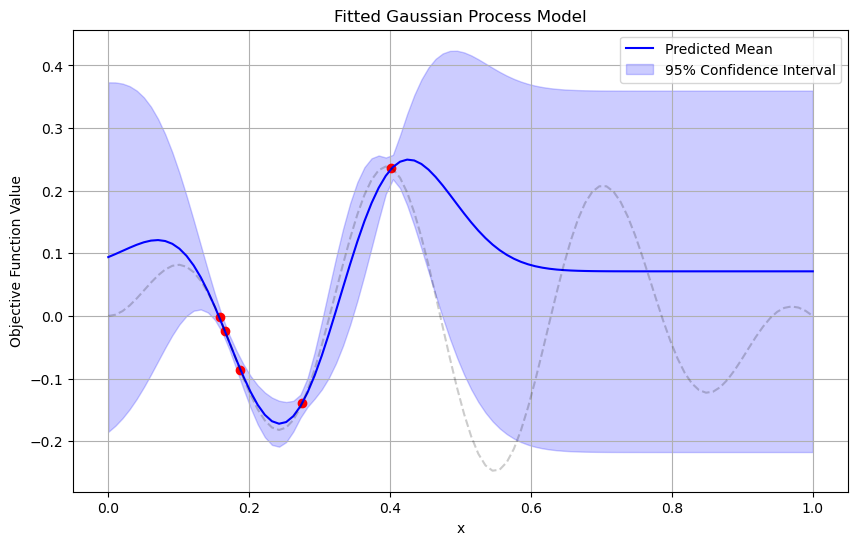

In [4]:
#학습 결과 확인
X_grid=torch.linspace(0.,1.,100) #학습 결과를 관찰할 좌표 생성
predictions=model.posterior(X_grid) #X_grid에서의 모델의 출력 생성
mean = predictions.mean.detach().numpy() #모델의 예측의 평균값 계산하여 numpy 배열로 변경 (미분 연산 관계식 제거)
lower, upper = predictions.mvn.confidence_region() #모델의 예측의 신뢰구간 생성

plt.figure(figsize=(10, 6)) #그림 크기 지정
plt.plot(X_train,Y_train,'ro') #실험 데이터  (빨간 점)
plt.plot(X_grid.numpy(), mean, label="Predicted Mean", color="blue") #평균값 파란 실선
plt.fill_between(
    X_grid.numpy(),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.2,
    label="95% Confidence Interval",
    color="blue"
)  #신뢰구간 색칠

plt.title("Fitted Gaussian Process Model") #그래프 제목
plt.xlabel("x") # x축
plt.ylabel("Objective Function Value") #y축
plt.legend(loc='best')  # 범례, 적절한 위치
plt.grid() # 그래프 격자
plt.plot(X_grid,objective_function(X_grid),'k--',alpha=0.2)  #underlying law
plt.show() #그래프 생성

In [19]:
# Step 3: Perform Bayesian Optimization
num_iterations = 10 #후보 생성 및 모델 재연산 횟수. 현실 문제에서는 1로 지정하여 후보만 추전 받으면 됨.
for iteration in range(num_iterations):
    # Define the acquisition function (Expected Improvement)
    ei = LogExpectedImprovement(model=model, best_f=Y_train.max(), maximize=True) #기대개선함수 생성
    # Optimize the acquisition function to find the next point
    candidate, _ = optimize_acqf(
        acq_function=ei,
        bounds=bounds,
        q=1,  # Single candidate
        num_restarts=5,
        raw_samples=20,
    ) #기대개선함수를 최적화하는 후보를 bounds 범위 내에서 생성, 
    # 이 다음은, 추천점에 대한 목적 함수를 바로 알 수 없는 현실 문제에는 적용 불가능    
    new_y = objective_function(candidate) #추천된 후보에 대한 목적함수 계산. 
    # Update the training data
    X_train = torch.cat([X_train, candidate], dim=0)
    Y_train = torch.cat([Y_train, new_y], dim=0)
    # Refit the model with the new data
    model = SingleTaskGP(X_train, Y_train)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

# Output the best point found
best_value, best_index = Y_train.max(0)
print(f"Best point: {X_train[best_index]}")
print(f"Best value: {best_value.item()}")
print(f"Candidate: {candidate}")

Best point: tensor([[0.3949]])
Best value: 0.238722526889093
Candidate: tensor([[0.3948]])


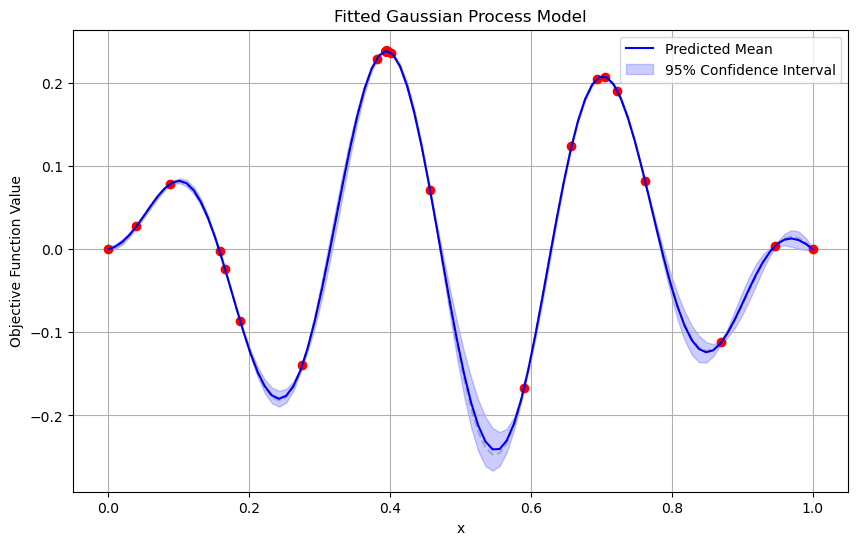

In [20]:
# 새로 학습된 결과 확인
predictions=model.posterior(X_grid)
mean = predictions.mean.detach().numpy()
lower, upper = predictions.mvn.confidence_region()
plt.figure(figsize=(10, 6))
plt.plot(X_train,Y_train,'ro')
plt.plot(X_grid.numpy(), mean, label="Predicted Mean", color="blue")
plt.fill_between(
    X_grid.numpy().squeeze(),
    lower.detach().numpy(),
    upper.detach().numpy(),
    alpha=0.2,
    label="95% Confidence Interval",
    color="blue"
)
plt.title("Fitted Gaussian Process Model")
plt.xlabel("x")
plt.ylabel("Objective Function Value")
plt.legend()
plt.grid()
plt.plot(X_grid,objective_function(X_grid),'k--',alpha=0.2)
plt.show()